In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    density_reports = pd.read_excel("DensityReports.xlsx")
    product_attributes = pd.read_excel("ProductAttributes.xlsx")
    supplier_scorecard = pd.read_excel("SupplierScorecard.xlsx")
    historical_incidents = pd.read_excel("HistoricalIncidents.xlsx")
except FileNotFoundError as e:
    print(f"File not found: {e}")

Now we normalize/standardize labels in the documents

## Density Data Revision

In [2]:
density_reports = pd.read_excel("DensityReports.xlsx")

# PackagingQuality
density_reports['PackagingQuality'] = density_reports['PackagingQuality'].str.strip().str.capitalize()
density_reports['PackagingQuality'] = density_reports['PackagingQuality'].replace({
    'Good': 'Good', 'GOOD': 'Good', 'good': 'Good', 'Bad': 'Bad', 'bad': 'Bad'
})
density_reports = density_reports[density_reports['PackagingQuality'].isin(['Good', 'Bad'])]

# SupplierName
density_reports['SupplierName'] = density_reports['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera" 
}

density_reports['SupplierName'] = density_reports['SupplierName'].replace(supplier_corrections)
density_reports['SupplierName'] = density_reports['SupplierName'].str.title() 

# Normalize ProposedFoldingMethod 
density_reports['ProposedFoldingMethod'] = density_reports['ProposedFoldingMethod'].str.replace('_', '', regex=False).str.strip().str.capitalize()

folding_correction = {
    "Methd1": "Method1",}
density_reports['ProposedFoldingMethod'] = density_reports['ProposedFoldingMethod'].replace(folding_correction)

# Normalize ProposedLayout 
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].str.strip().str.upper()

layout_corrections = {
    "LAYC": "LAYOUTC",
    "LAYOUTA": "LAYOUTA"
}
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].replace(layout_corrections)

valid_layouts = {'LAYOUTA', 'LAYOUTB', 'LAYOUTC', 'LAYOUTD', 'LAYOUTE'}
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].apply(lambda x: x if x in valid_layouts else 'LAYOUT_OTHER')


In [3]:
density_reports['ProposedFoldingMethod'].unique()


array(['Method2', 'Method1', 'Method3', nan, 'Foldx'], dtype=object)

## Historical Incident Data Revision

In [4]:
historical_incidents = pd.read_excel("HistoricalIncidents.xlsx")

#SupplierName Cleaning
historical_incidents['SupplierName'] = historical_incidents['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera"
}

historical_incidents['SupplierName'] = historical_incidents['SupplierName'].replace(supplier_corrections)
historical_incidents['SupplierName'] = historical_incidents['SupplierName'].str.title()

## Supplier Scorecard Data Revision

In [5]:
supplier_scorecard = pd.read_excel("SupplierScorecard.xlsx")

#SupplierName Cleaning
supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].str.strip().str.lower()

supplier_corrections = {
    "supla": "suppliera",
    "suppb": "supplierb",
    "supplierh": "supplierh",
    "splf": "supplierf",
    "supllierc": "supplierc",
    "suppliera": "suppliera"
}

supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].replace(supplier_corrections)
supplier_scorecard['SupplierName'] = supplier_scorecard['SupplierName'].str.title()

## Date Convention

Converting date columns to datetime objects (and moths to month format):

In [6]:
# Convert date columns to datetime objects
historical_incidents['DateOfIncident'] = pd.to_datetime(historical_incidents['DateOfIncident'])
density_reports['DateOfReport'] = pd.to_datetime(density_reports['DateOfReport'])
supplier_scorecard['Month'] = pd.to_datetime(supplier_scorecard['Month']).dt.to_period('M')


print(historical_incidents.info())
print(density_reports.info())
print(supplier_scorecard.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ProductReference  18000 non-null  object        
 1   SupplierName      18000 non-null  object        
 2   DateOfIncident    18000 non-null  datetime64[ns]
 3   IssueDescription  18000 non-null  object        
 4   ResolutionStatus  18000 non-null  object        
 5   CostImpact (€)    18000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 843.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 498137 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   ReportID                498137 non-null  object        
 1   ProductReference        498137 non-null  object        
 2   DateOfReport            498

Putting the entry values in descending order

In [7]:
density_reports = density_reports.sort_values(by='DateOfReport', ascending=False)
historical_incidents = historical_incidents.sort_values(by='DateOfIncident', ascending=False)
supplier_scorecard = supplier_scorecard.sort_values(by='Month', ascending=False)

## Product Reference Revision

In [8]:
# Get the unique ProductReference values from each DataFrame
product_attributes_refs = set(product_attributes['ProductReference'].unique())
density_refs = set(density_reports['ProductReference'].unique())
historical_refs = set(historical_incidents['ProductReference'].unique())

# Find ProductReference values missing from product_attributes
density_missing_refs = density_refs - product_attributes_refs
historical_missing_refs = historical_refs - product_attributes_refs

# Create a dictionary to track sources
from collections import defaultdict

missing_sources = defaultdict(set)

# Populate source info
for ref in density_missing_refs:
    missing_sources[ref].add('density_reports')
for ref in historical_missing_refs:
    missing_sources[ref].add('historical_incidents')

# Build the final DataFrame
missing_refs_df = pd.DataFrame([
    {
        'ProductReference': ref,
        'Source': 'both' if len(sources) > 1 else next(iter(sources))
    }
    for ref, sources in missing_sources.items()
])

missing_refs_df

,ProductReference,Source
0,PRD08303X,density_reports
1,PRD02818X,density_reports
2,PRD07569X,density_reports
3,PRD04150X,density_reports
4,PRD04329X,density_reports
...,...,...
5408,PRD07257X,density_reports
5409,PRD01365X,density_reports
5410,PRD06936X,density_reports
5411,PRD01419X,density_reports


Apparently the problem is in the trailing 'X' in the Product Reference

In [9]:
# Remove the final 'X' from ProductReference for all missing ones in the original DataFrame
density_reports['ProductReference'] = density_reports['ProductReference'].apply(
    lambda ref: ref[:-1] if isinstance(ref, str) and ref in density_missing_refs and ref.endswith('X') else ref
)

In [10]:
# Remove the final 'X' from ProductReference for all missing ones in the original DataFrame

historical_incidents['ProductReference'] = historical_incidents['ProductReference'].apply(
    lambda ref: ref[:-1] if isinstance(ref, str) and ref in density_missing_refs and ref.endswith('X') else ref
)

After correcting for the trailing 'X' we recheck again, which are the product references that are still missing

In [11]:
# Get the unique ProductReference values from each DataFrame
product_attributes_refs = set(product_attributes['ProductReference'].unique())
density_refs = set(density_reports['ProductReference'].unique())
historical_refs = set(historical_incidents['ProductReference'].unique())

# Find ProductReference values missing from product_attributes
density_missing_refs = density_refs - product_attributes_refs
historical_missing_refs = historical_refs - product_attributes_refs

# Create a dictionary to track sources
from collections import defaultdict

missing_sources = defaultdict(set)

# Populate source info
for ref in density_missing_refs:
    missing_sources[ref].add('density_reports')
for ref in historical_missing_refs:
    missing_sources[ref].add('historical_incidents')

# Build the final DataFrame
missing_refs_df = pd.DataFrame([
    {
        'ProductReference': ref,
        'Source': 'both' if len(sources) > 1 else next(iter(sources))
    }
    for ref, sources in missing_sources.items()
])

missing_refs_df

,ProductReference,Source
0,PRD02,both
1,PRD01,both
2,PRD06,both
3,PRD04,both
4,PRD07,both
5,PRD09,both
6,PRD08,both
7,PRD05,both
8,PRD00,both
9,PRD03,both


In [12]:
# Create a set of missing ProductReference values
missing_refs_set = set(missing_refs_df['ProductReference'])

# Function to pad ProductReference to 'PRD10000' format
def pad_product_reference(ref):
    if isinstance(ref, str) and ref.startswith('PRD'):
        numeric_part = ref[3:]
        padded_numeric = numeric_part.zfill(5)
        return f'PRD{padded_numeric}'
    return ref

# Apply padding in density_reports where ProductReference is in missing_refs_df
density_reports['ProductReference'] = density_reports['ProductReference'].apply(
    lambda ref: pad_product_reference(ref) if ref in missing_refs_set else ref
)

# Apply padding in historical_incidents where ProductReference is in missing_refs_df
historical_incidents['ProductReference'] = historical_incidents['ProductReference'].apply(
    lambda ref: pad_product_reference(ref) if ref in missing_refs_set else ref
)


In [13]:
# Get the unique ProductReference values from each DataFrame
product_attributes_refs = set(product_attributes['ProductReference'].unique())
density_refs = set(density_reports['ProductReference'].unique())
historical_refs = set(historical_incidents['ProductReference'].unique())

# Find ProductReference values missing from product_attributes
density_missing_refs = density_refs - product_attributes_refs
historical_missing_refs = historical_refs - product_attributes_refs

# Create a dictionary to track sources
from collections import defaultdict

missing_sources = defaultdict(set)

# Populate source info
for ref in density_missing_refs:
    missing_sources[ref].add('density_reports')
for ref in historical_missing_refs:
    missing_sources[ref].add('historical_incidents')

# Build the final DataFrame
missing_refs_df = pd.DataFrame([
    {
        'ProductReference': ref,
        'Source': 'both' if len(sources) > 1 else next(iter(sources))
    }
    for ref, sources in missing_sources.items()
])

missing_refs_df

,ProductReference,Source
0,PRD00000,both


In [14]:
density_reports[density_reports['ProductReference']=='PRD00000']

,ReportID,ProductReference,DateOfReport,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,PackagingQuality
387726,RPT0387727,PRD00000,2024-06-30,Supplierb,Shirt,Polyester,0.16,46.0,Method2,LAYOUTA,Good
168156,RPT0168157,PRD00000,2024-06-30,Suppliera,Shorts,Denim,0.39,23.0,Method2,LAYOUTC,Good
464584,RPT0464585,PRD00000,2024-06-30,Supplierc,Skirt,Linen,0.29,20.0,Method3,LAYOUTC,Good
375999,RPT0376000,PRD00000,2024-06-29,Suppliera,T-Shirt,Cotton,0.18,46.0,Method2,LAYOUTB,Good
354599,RPT0354600,PRD00000,2024-06-29,Suppliere,Shirt,Wool,0.22,28.0,Method3,LAYOUTB,Bad
...,...,...,...,...,...,...,...,...,...,...,...
208789,RPT0208790,PRD00000,2023-01-05,Supplierb,Blouse,Polyester,0.20,33.0,Method2,LAYOUTA,Good
162527,RPT0162528,PRD00000,2023-01-03,Suppliere,Shirt,Cotton,0.21,22.0,Method2,LAYOUTA,Good
421520,RPT0421521,PRD00000,2023-01-01,Supplierd,Shorts,Cotton,0.24,23.0,Method2,LAYOUTA,Good
306232,RPT0306233,PRD00000,2023-01-01,Supplierf,Jacket,Cotton,0.84,19.0,Method2,LAYOUTD,Good


## Density Descriptive

Index(['ReportID', 'ProductReference', 'DateOfReport', 'SupplierName',
       'GarmentType', 'Material', 'Weight', 'ProposedUnitsPerCarton',
       'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality'],
      dtype='object')
Value Counts for SupplierName:
SupplierName
Suppliera    141420
Supplierb    111891
Supplierc     75933
Supplierd     53213
Suppliere     40513
Supplierf     34374
Supplierg     25423
Supplierh     15370
Name: count, dtype: int64



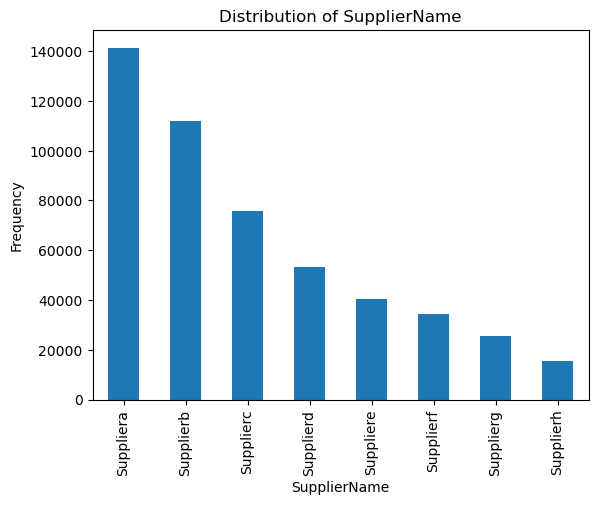

Value Counts for GarmentType:
GarmentType
Shirt      101422
Pants       75250
Jacket      51282
T-Shirt     48156
Dress       40703
Skirt       40575
Suit        29906
Shorts      26210
Coat        24509
Sweater     23529
Blouse      23392
Hoodie      13203
Name: count, dtype: int64



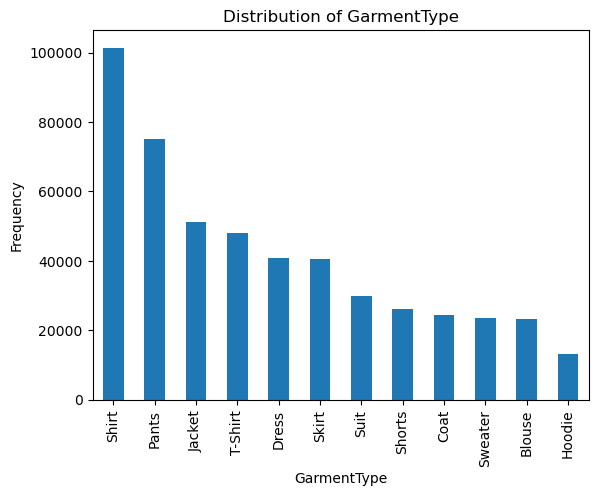

Value Counts for Material:
Material
Cotton       196262
Polyester    124787
Linen         50105
Wool          49182
Silk          41731
Denim         36070
Name: count, dtype: int64



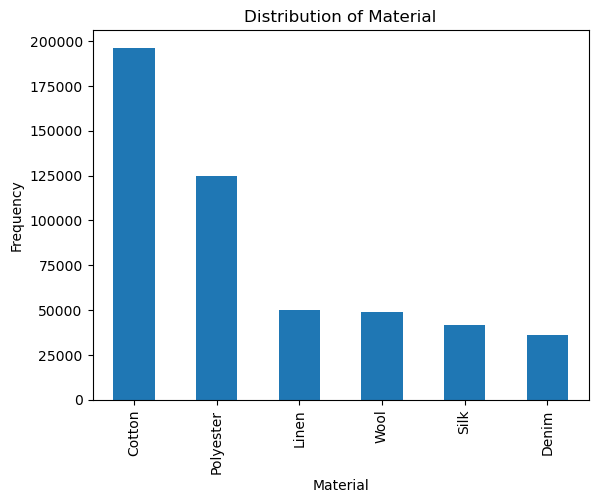

Value Counts for ProposedFoldingMethod:
ProposedFoldingMethod
Method2    219770
Method1    159503
Method3    113938
Foldx        2420
Name: count, dtype: int64



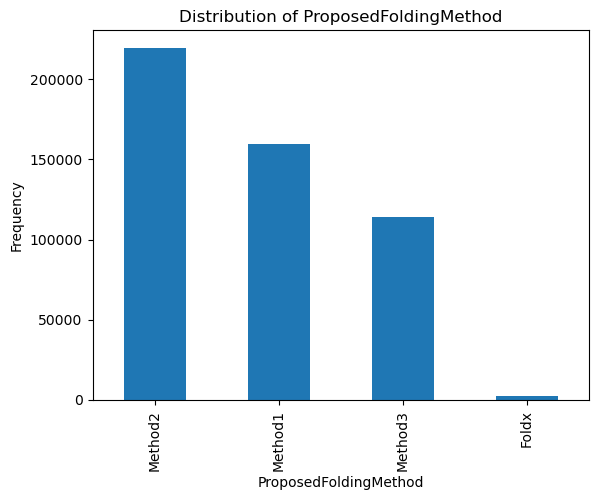

Value Counts for ProposedLayout:
ProposedLayout
LAYOUTB         179676
LAYOUTC         141306
LAYOUTA          86249
LAYOUTD          64439
LAYOUTE          21351
LAYOUT_OTHER      5116
Name: count, dtype: int64



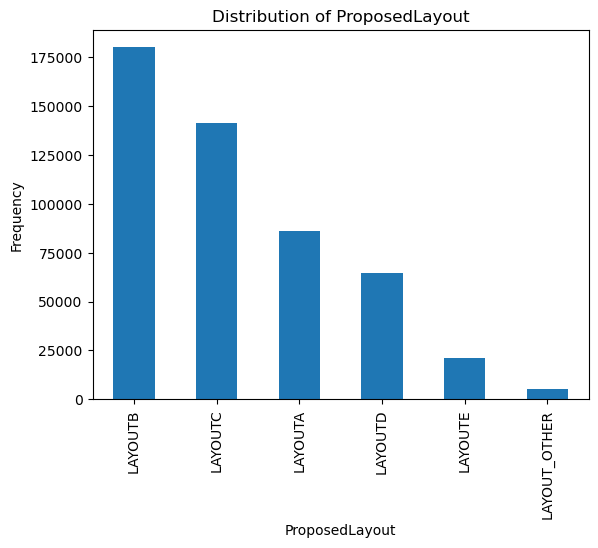

Value Counts for PackagingQuality:
PackagingQuality
Good    399252
Bad      98885
Name: count, dtype: int64



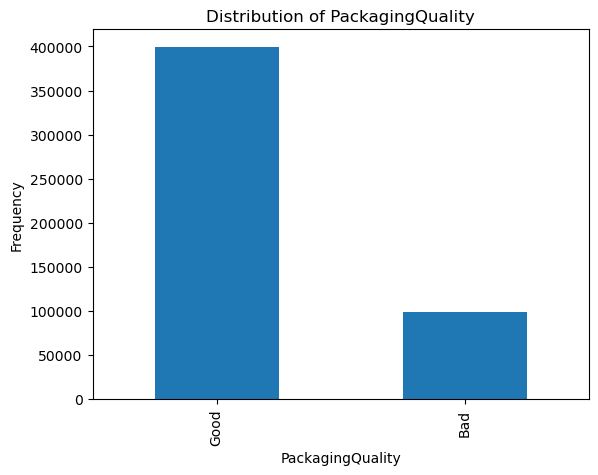

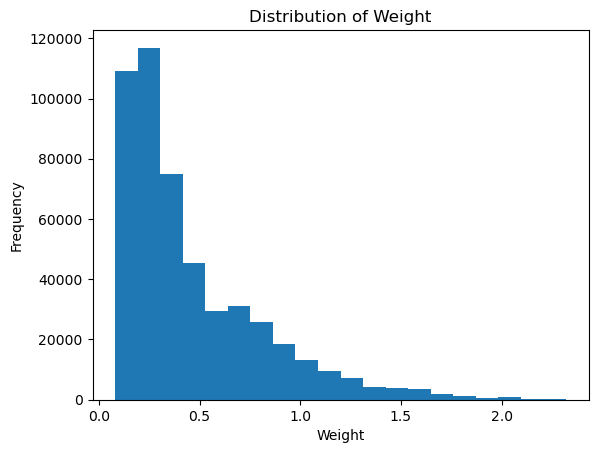

Summary statistics for Weight:
count    498137.000000
mean          0.460995
std           0.349701
min           0.080000
25%           0.210000
50%           0.330000
75%           0.620000
max           2.320000
Name: Weight, dtype: float64



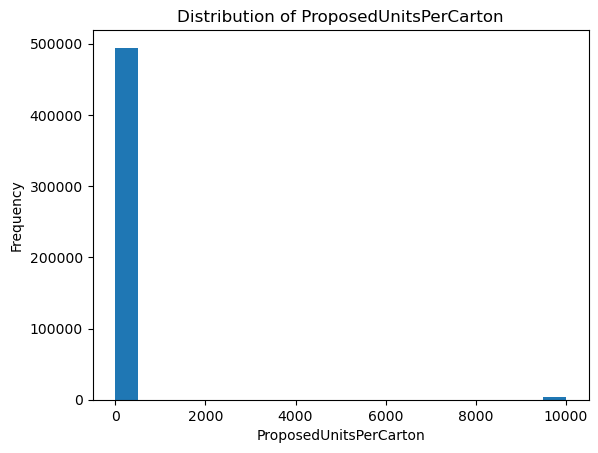

Summary statistics for ProposedUnitsPerCarton:
count    498137.000000
mean        100.123957
std         865.548860
min          -3.000000
25%          16.000000
50%          25.000000
75%          32.000000
max        9999.000000
Name: ProposedUnitsPerCarton, dtype: float64



In [36]:
print(density_reports.columns)

density_reports_numerical_cols = ['Weight', 'ProposedUnitsPerCarton']
density_reports_categorical_cols = ['SupplierName', 'GarmentType', 'Material', 'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality'] 

for col in density_reports_categorical_cols:
    if col in density_reports.columns:
        value_counts = density_reports[col].value_counts()
        print(f"Value Counts for {col}:\n{value_counts}\n")
        value_counts.plot(kind='bar', title=f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Warning: Column '{col}' not found in density_reports.")


for col in density_reports_numerical_cols:
    if col in density_reports.columns:
        plt.hist(density_reports[col], bins=20)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        stats = density_reports[col].describe()
        print(f"Summary statistics for {col}:\n{stats}\n")
    else:
        print(f"Warning: Column '{col}' not found in density_reports.")

## Product Attributes Descriptive

Value Counts for GarmentType:
GarmentType
Shirt      2043
Pants      1512
Jacket     1027
T-Shirt     969
Skirt       816
Dress       811
Suit        598
Shorts      522
Coat        497
Sweater     472
Blouse      469
Hoodie      264
Name: count, dtype: int64



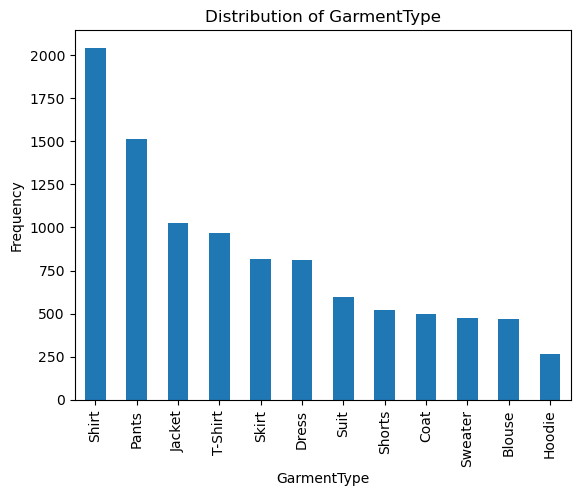

Value Counts for Material:
Material
Cotton       3926
Polyester    2512
Linen        1006
Wool          990
Silk          840
Denim         726
Name: count, dtype: int64



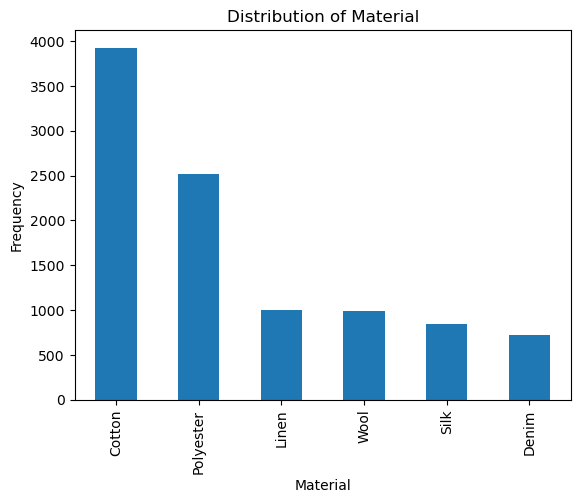

Value Counts for Size:
Size
M     3508
L     3039
S     1983
XL     988
XS     482
Name: count, dtype: int64



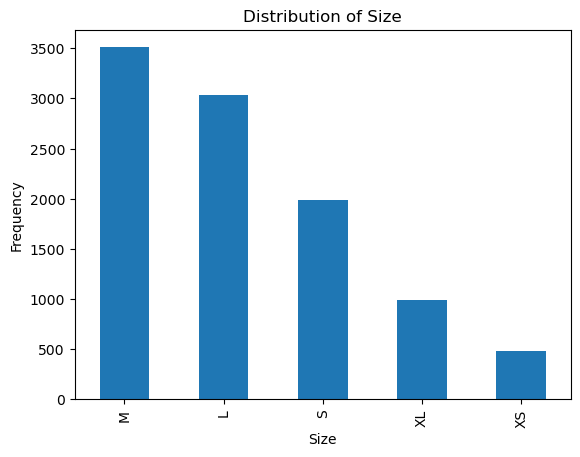

Value Counts for Collection:
Collection
Summer    3113
Winter    2897
Spring    2222
Autumn    1768
Name: count, dtype: int64



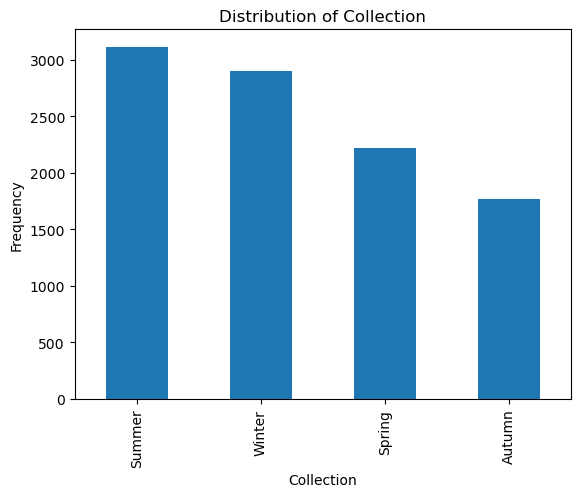

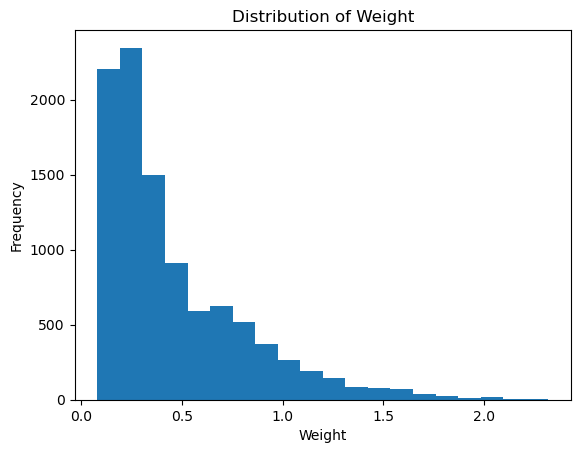

Summary statistics for Weight:
count    10000.000000
mean         0.461065
std          0.350351
min          0.080000
25%          0.200000
50%          0.330000
75%          0.620000
max          2.320000
Name: Weight, dtype: float64



In [18]:
product_attributes_numerical_cols = ['Weight']
product_attributes_categorical_cols = ['GarmentType', 'Material', 'Size', 'Collection']

for col in product_attributes_categorical_cols:
    value_counts = product_attributes[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in product_attributes_numerical_cols:
        plt.hist(product_attributes[col], bins=20)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        stats = product_attributes[col].describe()
        print(f"Summary statistics for {col}:\n{stats}\n")

## Supplier Scorecard Descriptive

In [38]:
supplier_scorecard.columns

Index(['SupplierName', 'Month', 'PackagesHandled', 'BadPackagingRate (%)',
       'TotalIncidents', 'AverageCostPerIncident (€)',
       'OnTimeDeliveryRate (%)', 'AnomaliesDetected'],
      dtype='object')

Value Counts for SupplierName:
SupplierName
Suppliera    54
Supplierf    36
Supplierb    36
Supplierh    36
Supplierc    36
Supplierd    18
Supplierg    18
Suppliere    18
Name: count, dtype: int64



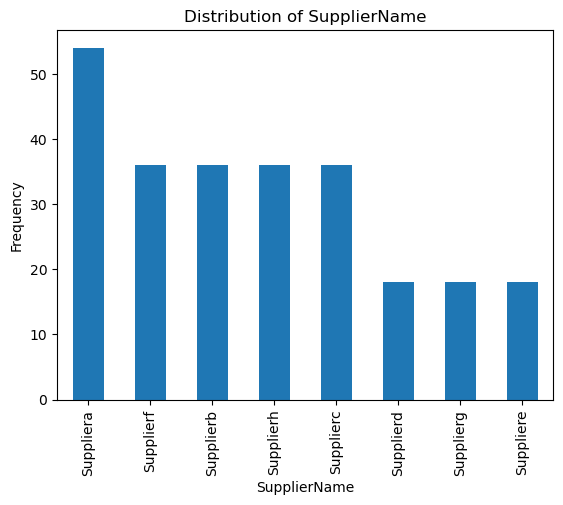

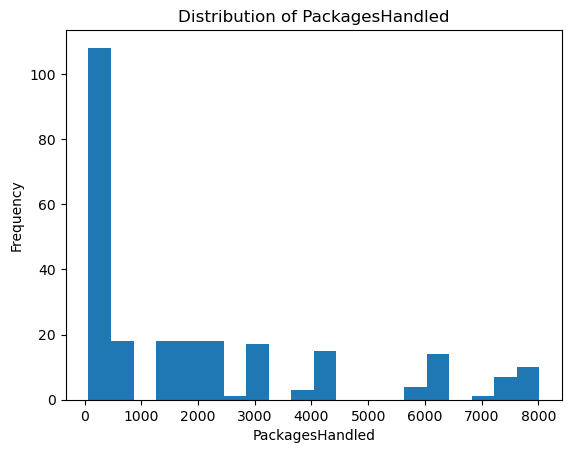

Summary statistics for PackagesHandled:
count     252.000000
mean     1984.126984
std      2382.575890
min        66.000000
25%        95.000000
50%      1097.000000
75%      2963.750000
max      8019.000000
Name: PackagesHandled, dtype: float64



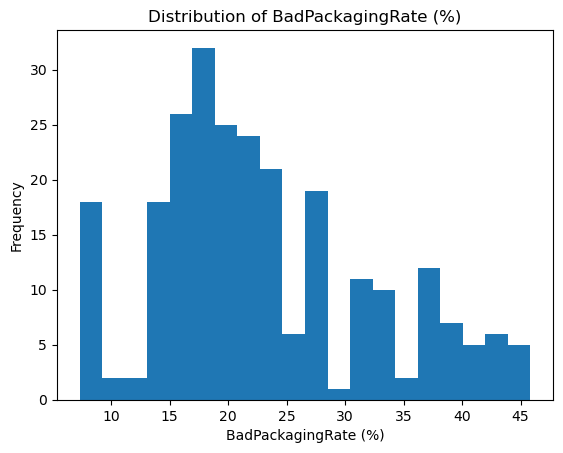

Summary statistics for BadPackagingRate (%):
count    252.000000
mean      23.047540
std        9.242888
min        7.290000
25%       16.652500
50%       21.000000
75%       27.510000
max       45.850000
Name: BadPackagingRate (%), dtype: float64



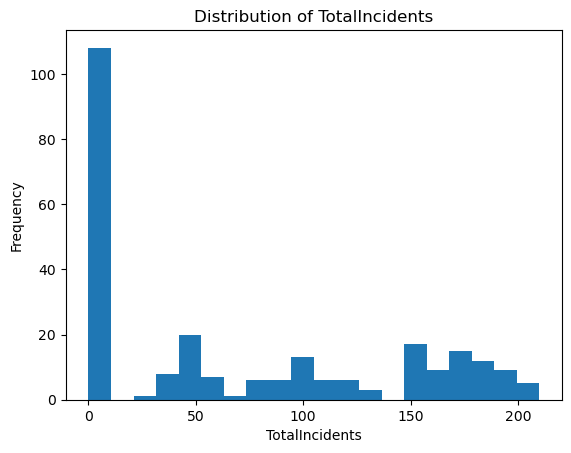

Summary statistics for TotalIncidents:
count    252.000000
mean      70.436508
std       71.666892
min        0.000000
25%        3.000000
50%       46.000000
75%      149.250000
max      210.000000
Name: TotalIncidents, dtype: float64



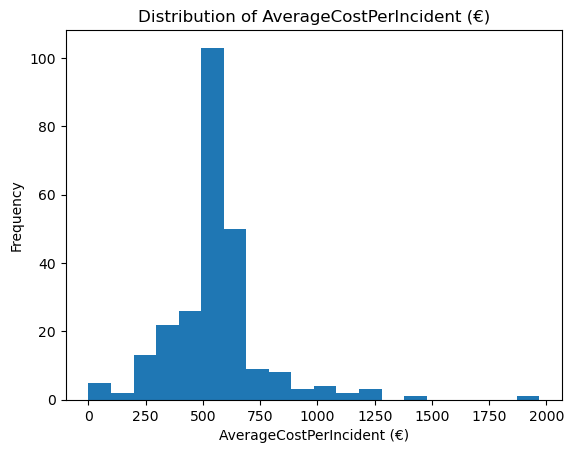

Summary statistics for AverageCostPerIncident (€):
count     252.000000
mean      552.654524
std       215.370064
min         0.000000
25%       483.457500
50%       544.090000
75%       611.607500
max      1969.000000
Name: AverageCostPerIncident (€), dtype: float64



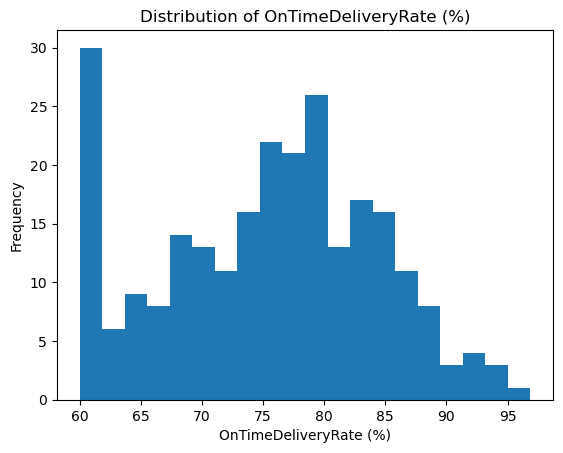

Summary statistics for OnTimeDeliveryRate (%):
count    252.000000
mean      75.397857
std        8.923621
min       60.000000
25%       68.837500
50%       76.395000
75%       81.950000
max       96.870000
Name: OnTimeDeliveryRate (%), dtype: float64



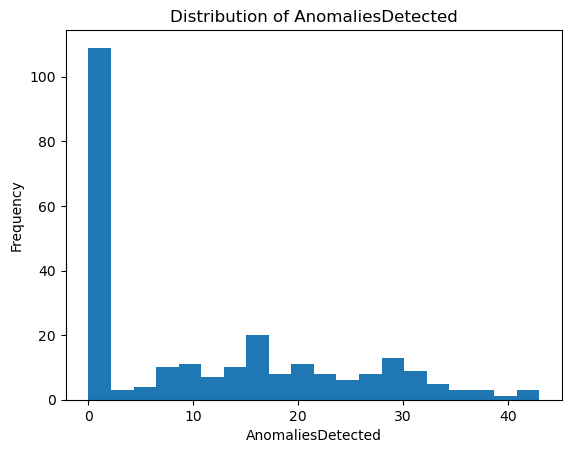

Summary statistics for AnomaliesDetected:
count    252.000000
mean      11.698413
std       12.036644
min        0.000000
25%        1.000000
50%        8.500000
75%       20.250000
max       43.000000
Name: AnomaliesDetected, dtype: float64



In [19]:
supplier_scorecard_numerical_cols = ['PackagesHandled', 'BadPackagingRate (%)', 'TotalIncidents', 'AverageCostPerIncident (€)', 'OnTimeDeliveryRate (%)', 'AnomaliesDetected']
supplier_scorecard_categorical_cols = ['SupplierName']

for col in supplier_scorecard_categorical_cols:
    value_counts = supplier_scorecard[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in supplier_scorecard_numerical_cols:
    plt.hist(supplier_scorecard[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    stats = supplier_scorecard[col].describe()
    print(f"Summary statistics for {col}:\n{stats}\n")

## Historical Incidents Descriptive

Value Counts for SupplierName:
SupplierName
Supplierc    3382
Supplierb    3356
Suppliera    3149
Supplierd    2758
Supplierf    1966
Suppliere    1627
Supplierh     937
Supplierg     825
Name: count, dtype: int64



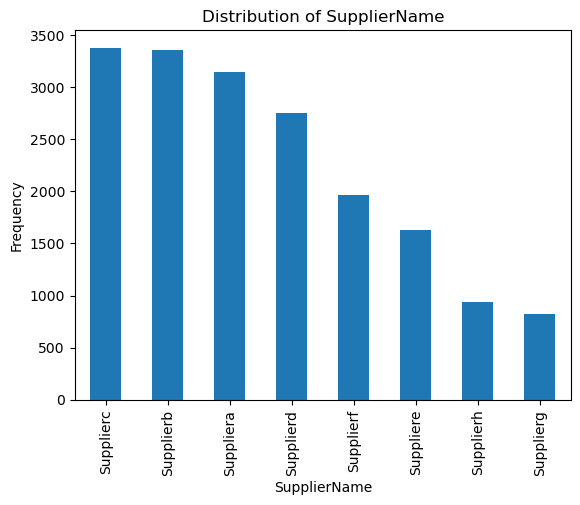

Value Counts for IssueDescription:
IssueDescription
Other                    5271
Labeling Error           4404
Packaging Damage         3454
Incorrect Folding        3243
Missing Items            1414
Transportation Damage     145
Product Wrinkled           69
Name: count, dtype: int64



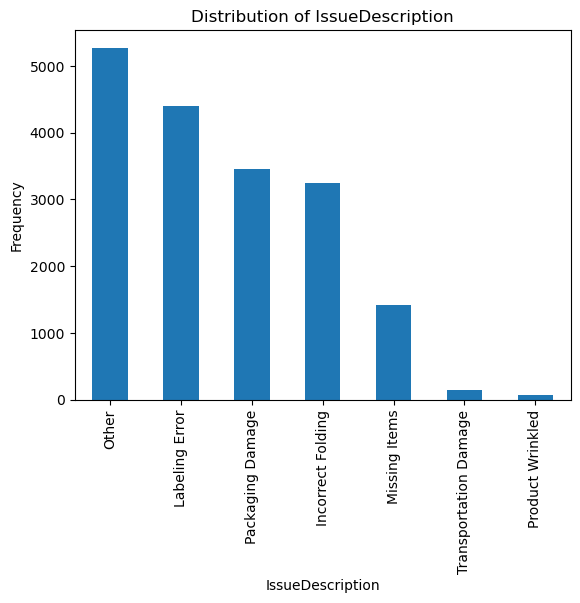

Value Counts for ResolutionStatus:
ResolutionStatus
Resolved        12538
In Progress      3617
Not Resolved     1845
Name: count, dtype: int64



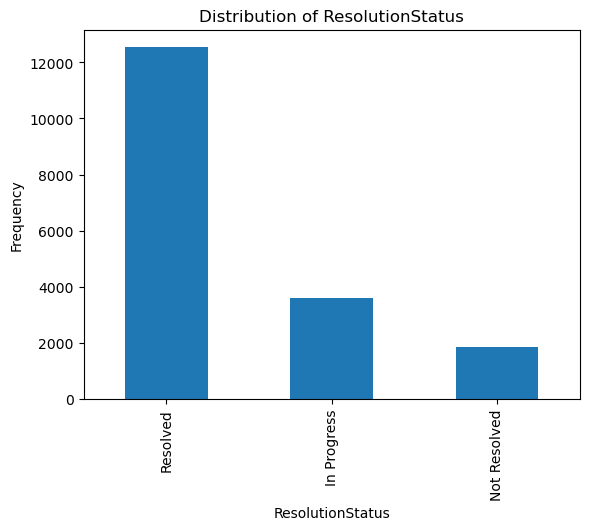

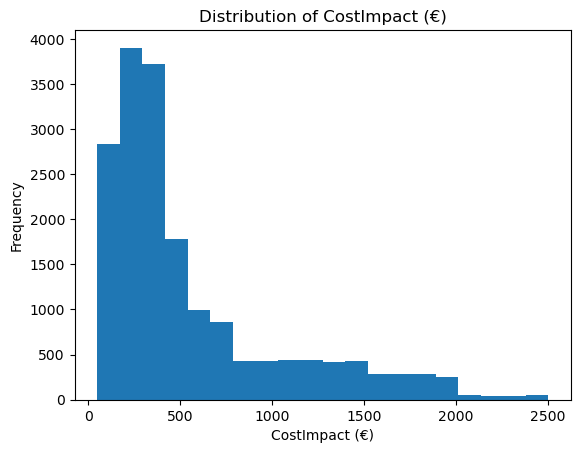

Summary statistics for CostImpact (€):
count    18000.000000
mean       555.215833
std        492.948178
min         50.000000
25%        224.000000
50%        365.000000
75%        693.750000
max       2500.000000
Name: CostImpact (€), dtype: float64



In [20]:
historical_incidents_numerical_cols = ['CostImpact (€)']
historical_incidents_categorical_cols = ['SupplierName', 'IssueDescription', 'ResolutionStatus']

for col in historical_incidents_categorical_cols:
    value_counts = historical_incidents[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")
    value_counts.plot(kind='bar', title=f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for col in historical_incidents_numerical_cols:
    plt.hist(historical_incidents[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    stats = historical_incidents[col].describe()
    print(f"Summary statistics for {col}:\n{stats}\n")

## Data Merging

In [40]:
density_reports.isna().sum()

ReportID                     0
ProductReference             0
DateOfReport                 0
SupplierName                 0
GarmentType                  0
Material                     0
Weight                       0
ProposedUnitsPerCarton       0
ProposedFoldingMethod     2506
ProposedLayout               0
PackagingQuality             0
dtype: int64

In [41]:
product_attributes.isna().sum()

ProductReference    0
ProductName         0
GarmentType         0
Material            0
Size                0
Collection          0
Weight              0
dtype: int64

In [23]:
density_reports_product_attributes_merged = pd.merge(density_reports, product_attributes, on='ProductReference', how='left')

DuplicateColumns = ['GarmentType_y', 'Material_y','Weight_y']
density_reports_product_attributes_merged.drop(DuplicateColumns, axis=1, inplace=True)

# Rename columns for clarity
density_reports_product_attributes_merged.rename(columns={'Material_x': 'Material',
                                                         'GarmentType_x': 'GarmentType',
                                                         'Weight_x': 'Weight'}, inplace=True)

print("Columns in merged DataFrame:", density_reports_product_attributes_merged.columns)

Columns in merged DataFrame: Index(['ReportID', 'ProductReference', 'DateOfReport', 'SupplierName',
       'GarmentType', 'Material', 'Weight', 'ProposedUnitsPerCarton',
       'ProposedFoldingMethod', 'ProposedLayout', 'PackagingQuality',
       'ProductName', 'Size', 'Collection'],
      dtype='object')


In [24]:
density_reports_product_attributes_merged.isna().sum()


ReportID                     0
ProductReference             0
DateOfReport                 0
SupplierName                 0
GarmentType                  0
Material                     0
Weight                       0
ProposedUnitsPerCarton       0
ProposedFoldingMethod     2506
ProposedLayout               0
PackagingQuality             0
ProductName                786
Size                       786
Collection                 786
dtype: int64

## Categorical / Continuos Crosstab

In [68]:
import plotly.express as px
import pandas as pd

density_reports_categorical_cols_merged = [
    'SupplierName', 'GarmentType', 'Material',
    'ProposedFoldingMethod', 'ProposedLayout',
    'ProductName', 'Size', 'Collection'
]

for col in density_reports_categorical_cols_merged:
    if col in density_reports_product_attributes_merged.columns:
        # Crosstab: counts of PackagingQuality per value of 'col'
        cross_tab = pd.crosstab(
            density_reports_product_attributes_merged[col],
            density_reports_product_attributes_merged['PackagingQuality']
        ).reset_index()

        # Melt to long-form for Plotly
        melted = cross_tab.melt(id_vars=col, var_name='PackagingQuality', value_name='Count')

        # Calculate total per category (for sorting)
        melted['Total'] = melted.groupby(col)['Count'].transform('sum')

        # Sort categories by total count (descending)
        melted[col] = pd.Categorical(melted[col],
                                     categories=melted.groupby(col)['Total'].max().sort_values(ascending=False).index,
                                     ordered=True)

        # Define custom color map
        custom_colors = {
            'Good': 'green',
            'Bad': 'red'
        }

        fig = px.bar(
            melted,
            x=col,
            y='Count',
            color='PackagingQuality',
            title=f'Packaging Quality by {col}',
            barmode='stack',
            color_discrete_map=custom_colors  # applies only to known labels
        )

        fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': melted[col].cat.categories.tolist()})
        fig.show()
    else:
        print(f"Warning: Column '{col}' not found in merged DataFrame.")


In [78]:
import plotly.express as px
import pandas as pd

density_reports_categorical_cols_merged = ['ProposedUnitsPerCarton']

for col in density_reports_categorical_cols_merged:
    if col in density_reports_product_attributes_merged.columns:
        df = density_reports_product_attributes_merged.copy()

        # Ensure column is numeric (in case it contains strings)
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Filter rows where the value is not NaN
        df = df[df[col].notna()]

        # Create a new column for display: 0-50 keep as is, >50 as "51+"
        df['Binned'] = df[col].apply(lambda x: str(int(x)) if x <= 50 else '51+')

        # Crosstab
        cross_tab = pd.crosstab(df['Binned'], df['PackagingQuality']).reset_index()

        # Melt to long format
        melted = cross_tab.melt(id_vars='Binned', var_name='PackagingQuality', value_name='Count')

        # Create custom category order: 0 to 50, then "51+"
        x_order = [str(i) for i in range(0, 51)] + ['51+']
        melted['Binned'] = pd.Categorical(melted['Binned'], categories=x_order, ordered=True)

        # Define colors
        custom_colors = {
            'Good': 'green',
            'Bad': 'red'
        }

        # Plot
        fig = px.bar(
            melted,
            x='Binned',
            y='Count',
            color='PackagingQuality',
            title=f'Packaging Quality by {col} (0–50 granular, 51+ grouped)',
            barmode='stack',
            color_discrete_map=custom_colors
        )

        fig.update_layout(
            xaxis=dict(
                categoryorder='array',
                categoryarray=x_order,
                title=col
            )
        )

        fig.show()


In [84]:
import plotly.express as px
import pandas as pd
import numpy as np

# Target column
col = 'Weight'

if col in density_reports_product_attributes_merged.columns:
    df = density_reports_product_attributes_merged.copy()

    # Ensure numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[df[col].notna()]

    # Automatic binning using Sturges' formula
    num_bins = int(np.ceil(np.log2(len(df[col])) + 1))
    df['WeightBin'] = pd.cut(df[col], bins=num_bins)

    # Crosstab by bin
    cross_tab = pd.crosstab(df['WeightBin'], df['PackagingQuality']).reset_index()

    # Melt for Plotly
    melted = cross_tab.melt(id_vars='WeightBin', var_name='PackagingQuality', value_name='Count')

    # Sort bin labels
    melted['WeightBin'] = melted['WeightBin'].astype(str)
    bin_order = df['WeightBin'].cat.categories.astype(str).tolist()
    melted['WeightBin'] = pd.Categorical(melted['WeightBin'], categories=bin_order, ordered=True)

    # Define custom colors
    custom_colors = {
        'Good': 'green',
        'Bad': 'red'
    }

    # Plot
    fig = px.bar(
        melted,
        x='WeightBin',
        y='Count',
        color='PackagingQuality',
        title='Packaging Quality by Weight (Binned)',
        barmode='stack',
        color_discrete_map=custom_colors
    )

    fig.update_layout(
        xaxis_title='Weight (Binned)',
        xaxis_tickangle=-45
    )

    fig.show()
else:
    print(f"Warning: Column '{col}' not found in merged DataFrame.")


## Outliers Analysis

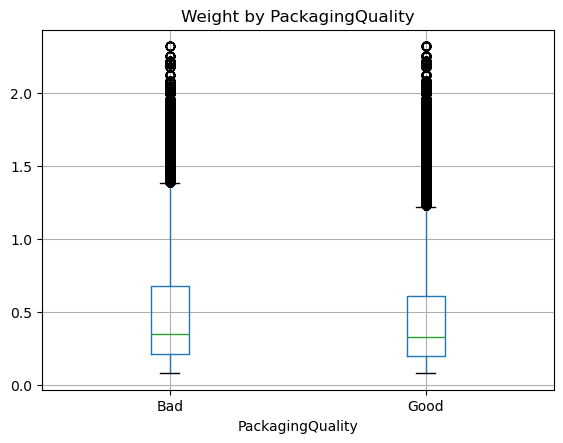

T-test P value : 5.957077837382592e-213


In [28]:
density_reports_product_attributes_merged.boxplot(column='Weight', by='PackagingQuality')
plt.title('Weight by PackagingQuality')
plt.suptitle("")
plt.show()

from scipy import stats
group0 = density_reports_product_attributes_merged[density_reports_product_attributes_merged["PackagingQuality"]=="Good"]["Weight"]
group1 = density_reports_product_attributes_merged[density_reports_product_attributes_merged["PackagingQuality"]=="Bad"]["Weight"]
result = stats.ttest_ind(group0, group1) #t-test
print(f"T-test P value : {result.pvalue}")

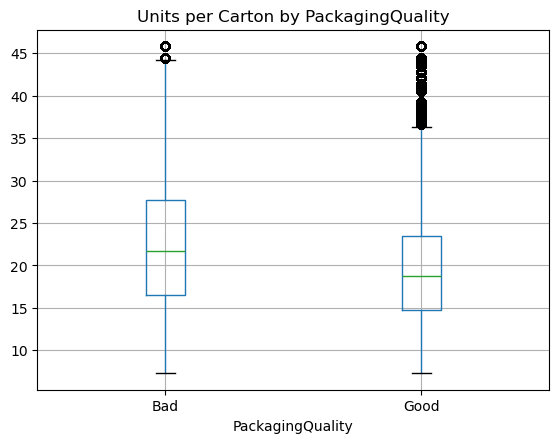

T-test P value : 0.0


In [29]:
density_reports_supplier_scorecard_merged = pd.merge(density_reports, supplier_scorecard, on='SupplierName', how='left')

density_reports_supplier_scorecard_merged.boxplot(column='BadPackagingRate (%)', by='PackagingQuality')
plt.title('Units per Carton by PackagingQuality')
plt.suptitle("")
plt.show()

from scipy import stats
group0 = density_reports_supplier_scorecard_merged[density_reports_supplier_scorecard_merged["PackagingQuality"]=="Good"]["BadPackagingRate (%)"]
group1 = density_reports_supplier_scorecard_merged[density_reports_supplier_scorecard_merged["PackagingQuality"]=="Bad"]["BadPackagingRate (%)"]
result = stats.ttest_ind(group0, group1)
print(f"T-test P value : {result.pvalue}")


/var/folders/kw/h652ds_j33g70dcfgpx2ldgr0000gn/T/ipykernel_25649/719905373.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = density_reports.set_index('DateOfReport').resample('M')['PackagingQuality'].value_counts().unstack()


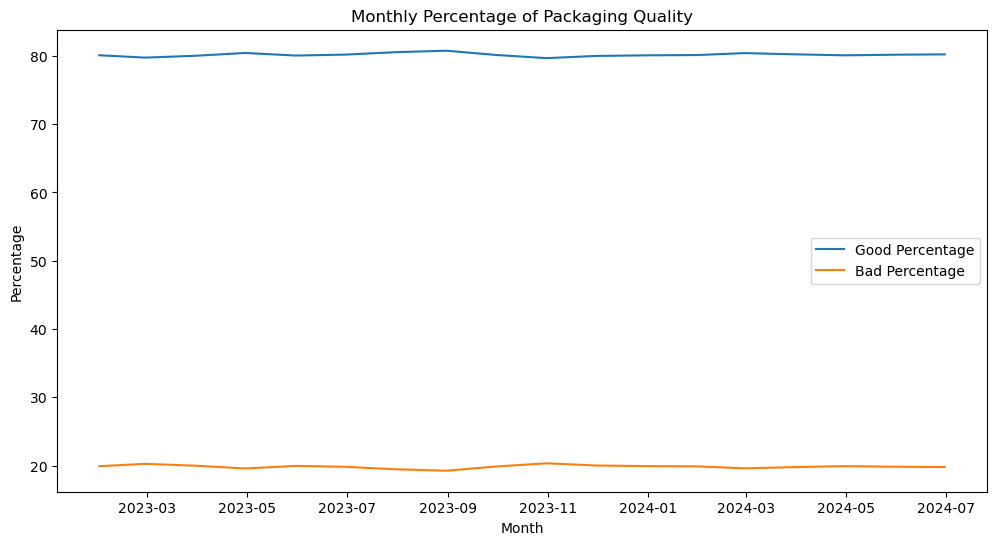

In [30]:
monthly_data = density_reports.set_index('DateOfReport').resample('M')['PackagingQuality'].value_counts().unstack()

monthly_data['Total'] = monthly_data['Good'] + monthly_data['Bad']
monthly_data['Good_Percentage'] = (monthly_data['Good'] / monthly_data['Total']) * 100
monthly_data['Bad_Percentage'] = (monthly_data['Bad'] / monthly_data['Total']) * 100

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Good_Percentage'], label='Good Percentage')
plt.plot(monthly_data.index, monthly_data['Bad_Percentage'], label='Bad Percentage')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Monthly Percentage of Packaging Quality')
plt.legend()
plt.show()

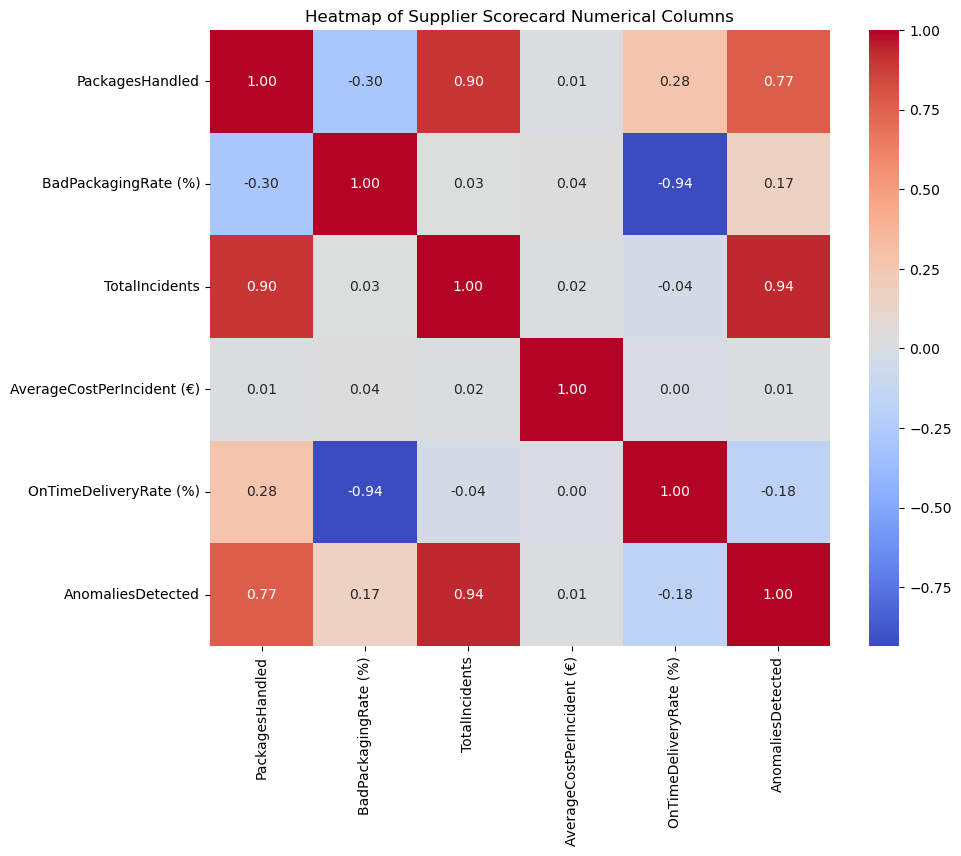

In [31]:
supplier_scorecard_numerical_cols = ['PackagesHandled', 'BadPackagingRate (%)', 'TotalIncidents', 'AverageCostPerIncident (€)', 'OnTimeDeliveryRate (%)', 'AnomaliesDetected']

supplier_scorecard_numeric = supplier_scorecard[supplier_scorecard_numerical_cols]

correlation_matrix = supplier_scorecard_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Supplier Scorecard Numerical Columns')
plt.show()

Outlier Summary: Distribution Overview

Summary statistics for 'Weight':
count    20000.000000
mean         0.458865
std          0.351012
min          0.080000
25%          0.210000
50%          0.330000
75%          0.610000
max          2.250000
Name: Weight, dtype: float64

Summary statistics for 'ProposedUnitsPerCarton':
count    20000.000000
mean        99.327675
std        860.666077
min         -3.000000
25%         16.000000
50%         25.000000
75%         32.000000
max       9999.000000
Name: ProposedUnitsPerCarton, dtype: float64



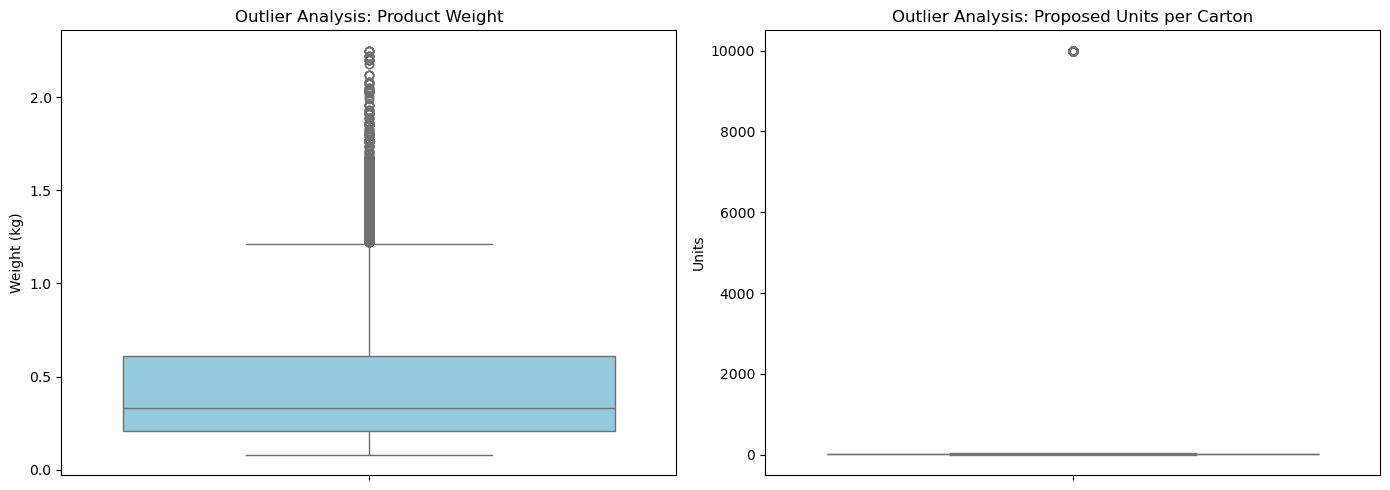

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

density = pd.read_excel("DensityReports.xlsx", nrows=20000)

print("Outlier Summary: Distribution Overview\n")

numerical_cols = ['Weight', 'ProposedUnitsPerCarton']

for col in numerical_cols:
    stats = density[col].describe()
    print(f"Summary statistics for '{col}':\n{stats}\n")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=density['Weight'], color='skyblue')
plt.title("Outlier Analysis: Product Weight")
plt.ylabel("Weight (kg)")

plt.subplot(1, 2, 2)
sns.boxplot(y=density['ProposedUnitsPerCarton'], color='lightgreen')
plt.title("Outlier Analysis: Proposed Units per Carton")
plt.ylabel("Units")

plt.tight_layout()
plt.show()

/var/folders/kw/h652ds_j33g70dcfgpx2ldgr0000gn/T/ipykernel_25649/1822600663.py:34: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
/var/folders/kw/h652ds_j33g70dcfgpx2ldgr0000gn/T/ipykernel_25649/1822600663.py:34: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()
/var/folders/kw/h652ds_j33g70dcfgpx2ldgr0000gn/T/ipykernel_25649/1822600663.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: Us

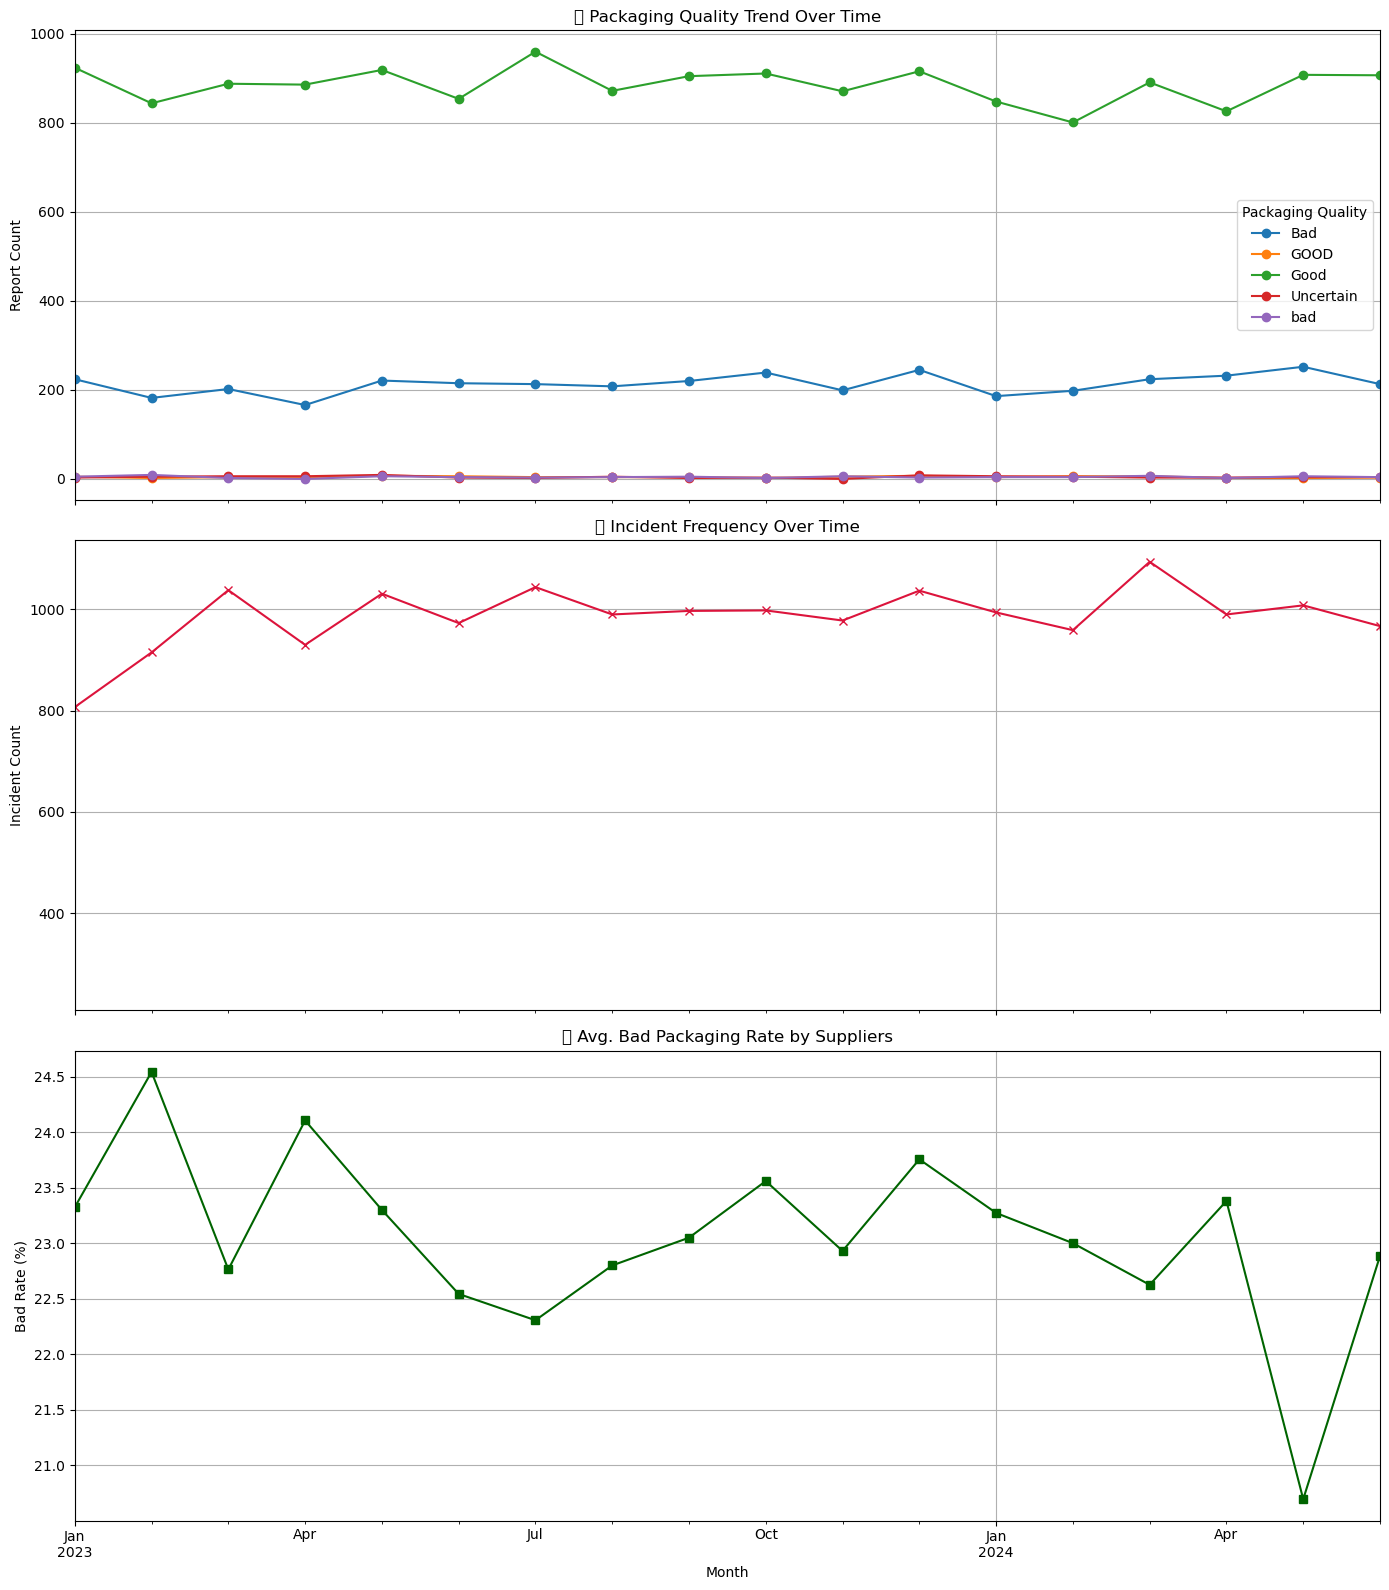

In [33]:
supplier = pd.read_excel("SupplierScorecard.xlsx")
incidents = pd.read_excel("HistoricalIncidents.xlsx")

density['DateOfReport'] = pd.to_datetime(density['DateOfReport'])
density['ReportMonth'] = density['DateOfReport'].dt.to_period('M')

incidents['DateOfIncident'] = pd.to_datetime(incidents['DateOfIncident'])
incidents['IncidentMonth'] = incidents['DateOfIncident'].dt.to_period('M')

supplier['Month'] = pd.to_datetime(supplier['Month'], errors='coerce').dt.to_period('M')

quality_monthly = density.groupby(['ReportMonth', 'PackagingQuality']).size().unstack().fillna(0)

incident_monthly = incidents.groupby('IncidentMonth').size()

bad_rate_monthly = supplier.groupby('Month')["BadPackagingRate (%)"].mean()

fig, axs = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

quality_monthly.plot(ax=axs[0], marker='o', title="📦 Packaging Quality Trend Over Time")
axs[0].set_ylabel("Report Count")
axs[0].legend(title="Packaging Quality")
axs[0].grid(True)

incident_monthly.plot(ax=axs[1], color='crimson', marker='x', title="🚨 Incident Frequency Over Time")
axs[1].set_ylabel("Incident Count")
axs[1].grid(True)

bad_rate_monthly.plot(ax=axs[2], color='darkgreen', marker='s', title="📉 Avg. Bad Packaging Rate by Suppliers")
axs[2].set_ylabel("Bad Rate (%)")
axs[2].set_xlabel("Month")
axs[2].grid(True)

plt.tight_layout()
plt.show()